## **Environment Setup**

In [ ]:
import os
import pandas as pd
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Cropping2D, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers, regularizers
import tensorflow as tf
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.optimizers import schedules
from keras.layers import Average
from google.colab.patches import cv2_imshow
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.datasets import mnist
from keras.applications import vgg16, vgg19, resnet, inception_v3
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory



## **Check GPU Setting**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 12 01:24:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Step 1: Train & Test Set Path Setup**

Start training:
Source: https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
base_dir = '/content/gdrive/My Drive/Image_Search/model_dataset_split/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


BATCH_SIZE = 2
IMG_SIZE = (2000, 2000)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,label_mode='categorical')

Found 1102 files belonging to 31 classes.


In [ ]:
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,label_mode='categorical')

Found 303 files belonging to 31 classes.


In [ ]:
print((train_dataset))

<BatchDataset shapes: ((None, 2000, 2000, 3), (None, 31)), types: (tf.float32, tf.float32)>


In [ ]:
print((test_dataset))

<BatchDataset shapes: ((None, 2000, 2000, 3), (None, 31)), types: (tf.float32, tf.float32)>


## **Step 2: Image Augmentation**
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 2

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=2,
        #shear_range=0.1,
        #zoom_range=0.1,
        #width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        #fill_mode='nearest'
        )



# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest'
        )

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(2000, 2000),  # all images will be resized to 2000x2000
        batch_size=batch_size,
        class_mode='categorical', seed=2021)  # set class mode to categorical as we have more than 2 clases
                                              # set seed to 2021 to maintain sames set of training images generated

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(2000, 2000),
        batch_size=batch_size,
        class_mode='categorical', seed=2021)


Found 1102 images belonging to 31 classes.
Found 303 images belonging to 31 classes.


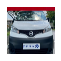

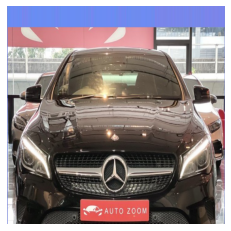

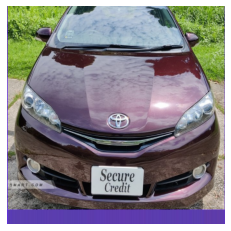

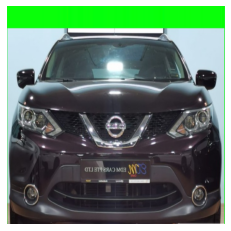

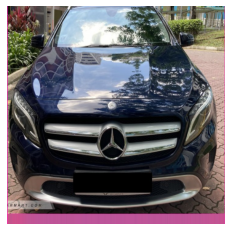

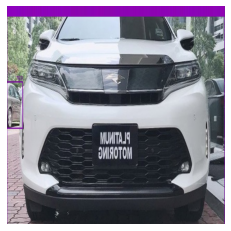

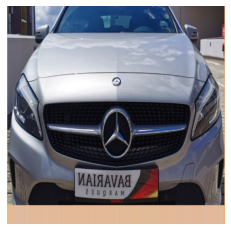

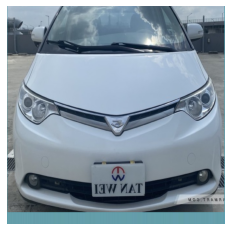

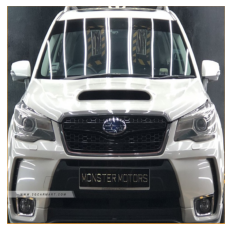

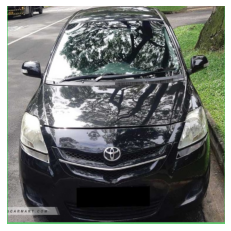

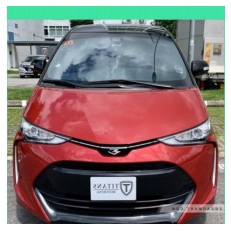

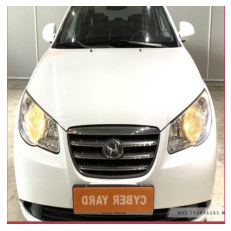

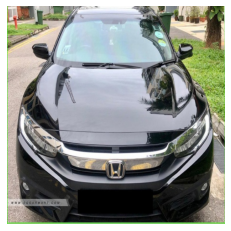

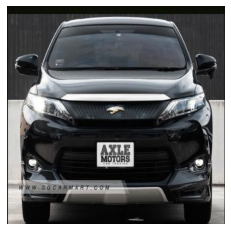

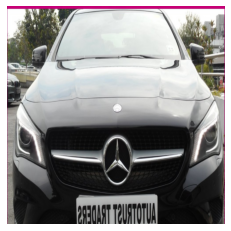

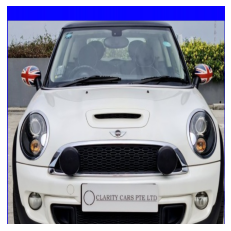

In [ ]:
fig = plt.figure()
i=0

for i in range(16):

    img, label = train_generator.next()


    fig.add_subplot(4, 4, i+1)
    plt.imshow(img[0])

    plt.axis('off')
    plt.show()

In [ ]:
# check the index and label of our 31 classes
label_map = (validation_generator.class_indices)
label_map

{'Audi A3': 0,
 'BMW 5': 1,
 'Honda Civic': 2,
 'Honda Odyssey': 3,
 'Honda Stream': 4,
 'Hyundai Avante': 5,
 'Hyundai Elantra': 6,
 'Kia Cerato': 7,
 'MINI Cooper': 8,
 'Mazda 3': 9,
 'Mercedes-Benz A-Class': 10,
 'Mercedes-Benz C-Class': 11,
 'Mercedes-Benz CLA-Class': 12,
 'Mercedes-Benz E-Class': 13,
 'Mercedes-Benz GLA-Class': 14,
 'Mercedes-Benz S-Class': 15,
 'Mitsubishi Lancer': 16,
 'Nissan NV200': 17,
 'Nissan Qashqai': 18,
 'Subaru Forester': 19,
 'Suzuki Swift': 20,
 'Toyota Camry': 21,
 'Toyota Corolla': 22,
 'Toyota Estima': 23,
 'Toyota Harrier': 24,
 'Toyota Hiace': 25,
 'Toyota Sienta': 26,
 'Toyota Vios': 27,
 'Toyota Wish': 28,
 'Volkswagen Golf': 29,
 'Volkswagen Scirocco': 30}

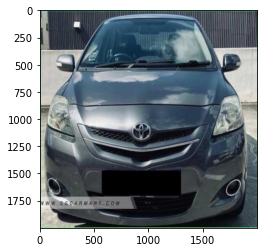

In [ ]:
import cv2
import matplotlib.pyplot as plt

#try to plot one image from folder to check the coordinates system
im = cv2.imread('/content/gdrive/My Drive/Image_Search/model_dataset_split/train/Toyota Vios/1010066_____1036.jpg')
crop_img = cv2.resize(im, (2000, 2000), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
plt.show()

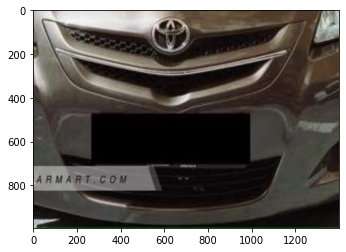

In [ ]:
import cv2
im = cv2.imread('/content/gdrive/My Drive/Image_Search/model_dataset_split/train/Toyota Vios/1010066_____1036.jpg')
crop_img = cv2.resize(im, (2000, 2000), interpolation=cv2.INTER_LINEAR)
crop_img2 = crop_img[1000:1995, 300:1700]
plt.imshow(crop_img2)
plt.show()

## **Step 3: Baseline Model**

We use a multi-layer convolutional net model as our baseline model. The baseline model is applied to the raw pixel data.

In [ ]:
#set learning rate to 0.001
optmz       = tf.keras.optimizers.Adam(lr=0.001)

model = Sequential()
#https://keras.io/api/layers/reshaping_layers/cropping2d/
#crop image to contain only the lower front area of the car. After few trials, we identified the
#upper part of the cars are quite similar among all classes and it reduced the accuracy of models
model.add(Cropping2D(cropping=((1000, 5), (5, 5)), input_shape=(2000,2000,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(31, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optmz,metrics=['accuracy'])

model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_3 (Cropping2D)   (None, 995, 1990, 3)      0         
                                                                 
 conv2d (Conv2D)             (None, 995, 1990, 32)     896       
                                                                 
 batch_normalization (BatchN  (None, 995, 1990, 32)    128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 995, 1990, 32)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 497, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 248, 497, 32)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# callbacks:  https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202

my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_baseline.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1),

    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

]



history=model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
551/551 [==============================] - ETA: 0s - loss: 6.9541 - accuracy: 0.1561
Epoch 00001: val_accuracy improved from -inf to 0.22848, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_baseline.hdf5
551/551 [==============================] - 1222s 2s/step - loss: 6.9541 - accuracy: 0.1561 - val_loss: 2.9207 - val_accuracy: 0.2285
Epoch 2/50
551/551 [==============================] - ETA: 0s - loss: 2.2954 - accuracy: 0.4002
Epoch 00002: val_accuracy improved from 0.22848 to 0.41722, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_baseline.hdf5
551/551 [==============================] - 757s 1s/step - loss: 2.2954 - accuracy: 0.4002 - val_loss: 2.1719 - val_accuracy: 0.4172
Epoch 3/50
551/551 [==============================] - ETA: 0s - loss: 1.6777 - accuracy: 0.5345
Epoch 00003: val_accuracy improved from 0.41722 to 0.47351, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model

In [ ]:
model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_baseline.hdf5")
model.summary


In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1
import numpy as np
from sklearn.metrics import classification_report

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.00      0.00      0.00        10
         2.0       1.00      0.10      0.18        10
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        11
         7.0       0.00      0.00      0.00        10
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00        11
        10.0       0.00      0.00      0.00         7
        11.0       0.00      0.00      0.00         8
        12.0       0.00      0.00      0.00        10
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00         9
        15.0       0.00      0.00      0.00        10
        16.0       0.04      1.00      0.08        12
        17.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


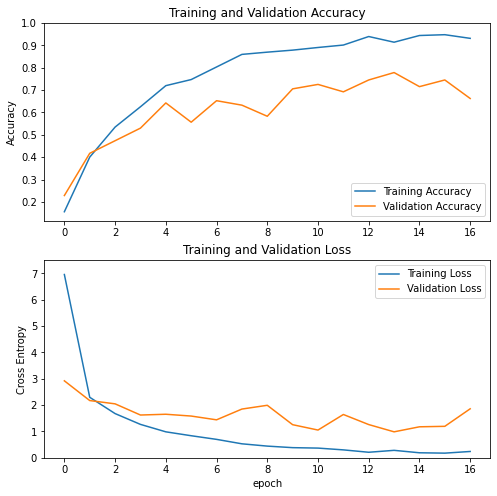

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,7.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Step 4: Pre-Trained Model - VGG16**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2000, 2000, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 2000, 2000, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 2000, 2000, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 1000, 1000, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, 1000, 1000, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 1000, 1000, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 500, 500, 128)     0     

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=(995,1400,3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False



pretrain_vgg_model = Sequential()
pretrain_vgg_model.add(Cropping2D(cropping=((1000, 5), (300, 300)), input_shape=(2000,2000,3)))
pretrain_vgg_model.add(vgg_model)

pretrain_vgg_model.add(Dense(31,kernel_regularizer=regularizers.l2(0.001), activation='softmax'))

pretrain_vgg_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

pretrain_vgg_model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_4 (Cropping2D)   (None, 995, 1400, 3)      0         
                                                                 
 model_3 (Functional)        (None, 682496)            14714688  
                                                                 
 dense_4 (Dense)             (None, 31)                21157407  
                                                                 
Total params: 35,872,095
Trainable params: 21,157,407
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# callbacks:  https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202

my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

]




history_pretrained_vgg=pretrain_vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
551/551 [==============================] - 1399s 3s/step - loss: 122.2337 - accuracy: 0.1878 - val_loss: 112.0891 - val_accuracy: 0.1887

Epoch 00001: val_accuracy improved from -inf to 0.18874, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG.hdf5
Epoch 2/50
551/551 [==============================] - 943s 2s/step - loss: 81.4560 - accuracy: 0.4102 - val_loss: 92.4886 - val_accuracy: 0.3974

Epoch 00002: val_accuracy improved from 0.18874 to 0.39735, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG.hdf5
Epoch 3/50
551/551 [==============================] - 929s 2s/step - loss: 69.7027 - accuracy: 0.4791 - val_loss: 56.1853 - val_accuracy: 0.5397

Epoch 00003: val_accuracy improved from 0.39735 to 0.53974, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG.hdf5
Epoch 4/50
551/551 [==============================] - 926s 2s/step - loss: 74.3

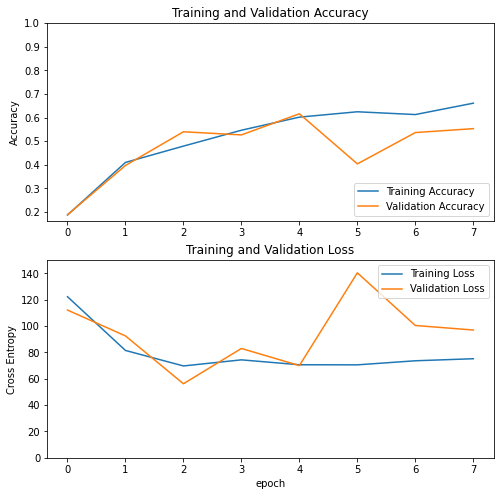

In [ ]:
acc = history_pretrained_vgg.history['accuracy']
val_acc = history_pretrained_vgg.history['val_accuracy']

loss = history_pretrained_vgg.history['loss']
val_loss = history_pretrained_vgg.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,150.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pretrain_vgg_model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG.hdf5")
pretrain_vgg_model.summary


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f5bf9957cd0>>

In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1


prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(pretrain_vgg_model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.37      1.00      0.54         7
         1.0       0.82      0.90      0.86        10
         2.0       0.67      0.40      0.50        10
         3.0       1.00      0.80      0.89        10
         4.0       1.00      0.58      0.74        12
         5.0       0.58      1.00      0.74         7
         6.0       1.00      1.00      1.00        11
         7.0       0.00      0.00      0.00        10
         8.0       0.40      0.73      0.52        11
         9.0       1.00      0.18      0.31        11
        10.0       0.50      0.43      0.46         7
        11.0       0.21      0.62      0.31         8
        12.0       0.33      0.10      0.15        10
        13.0       0.36      0.40      0.38        10
        14.0       0.53      1.00      0.69         9
        15.0       1.00      0.90      0.95        10
        16.0       1.00      0.33      0.50        12
        17.0       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Step 5: Pre-Trained Model - VGG19**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2000, 2000, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 2000, 2000, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 2000, 2000, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 1000, 1000, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, 1000, 1000, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 1000, 1000, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 500, 500, 128)     0     

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


vgg2 = vgg19.VGG19(include_top=False, weights='imagenet',
                                     input_shape=(995,1400,3))

output = vgg2.layers[-1].output
output = keras.layers.Flatten()(output)
vgg19_model = Model(vgg2.input, output)

vgg19_model.trainable = False
for layer in vgg19_model.layers:
    layer.trainable = False

pretrain_vgg19_model = Sequential()
pretrain_vgg19_model.add(Cropping2D(cropping=((1000, 5), (300, 300)), input_shape=(2000,2000,3)))
pretrain_vgg19_model.add(vgg19_model)

pretrain_vgg19_model.add(Dense(31,kernel_regularizer=regularizers.l2(0.001), activation='softmax'))

pretrain_vgg19_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

pretrain_vgg19_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_2 (Cropping2D)   (None, 995, 1400, 3)      0         
                                                                 
 model_2 (Functional)        (None, 682496)            20024384  
                                                                 
 dense_2 (Dense)             (None, 31)                21157407  
                                                                 
Total params: 41,181,791
Trainable params: 21,157,407
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# callbacks:  https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
from keras.callbacks import ModelCheckpoint

my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG19.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

]




history_pretrained_vgg19=pretrain_vgg19_model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
551/551 [==============================] - ETA: 0s - loss: 142.2754 - accuracy: 0.1642
Epoch 00001: val_accuracy improved from -inf to 0.32119, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG19.hdf5
551/551 [==============================] - 1130s 2s/step - loss: 142.2754 - accuracy: 0.1642 - val_loss: 117.0947 - val_accuracy: 0.3212
Epoch 2/50
551/551 [==============================] - ETA: 0s - loss: 98.9923 - accuracy: 0.3557
Epoch 00002: val_accuracy improved from 0.32119 to 0.39404, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG19.hdf5
551/551 [==============================] - 782s 1s/step - loss: 98.9923 - accuracy: 0.3557 - val_loss: 80.9202 - val_accuracy: 0.3940
Epoch 3/50
551/551 [==============================] - ETA: 0s - loss: 92.8552 - accuracy: 0.4510
Epoch 00003: val_accuracy improved from 0.39404 to 0.44702, saving model to /content/gdrive/My Drive/ISY5002/Proje

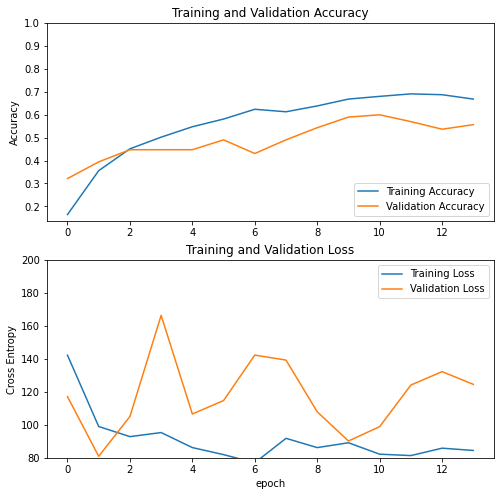

In [ ]:
acc = history_pretrained_vgg19.history['accuracy']
val_acc = history_pretrained_vgg19.history['val_accuracy']

loss = history_pretrained_vgg19.history['loss']
val_loss = history_pretrained_vgg19.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([80,200.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1
import numpy as np
from sklearn.metrics import classification_report

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(pretrain_vgg19_model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52         7
         1.0       0.83      1.00      0.91        10
         2.0       0.71      1.00      0.83        10
         3.0       0.40      0.80      0.53        10
         4.0       1.00      0.67      0.80        12
         5.0       1.00      0.86      0.92         7
         6.0       1.00      0.91      0.95        11
         7.0       0.00      0.00      0.00        10
         8.0       0.43      0.82      0.56        11
         9.0       1.00      0.91      0.95        11
        10.0       0.67      0.29      0.40         7
        11.0       0.29      0.62      0.40         8
        12.0       0.56      0.50      0.53        10
        13.0       0.25      0.80      0.38        10
        14.0       1.00      0.67      0.80         9
        15.0       1.00      0.90      0.95        10
        16.0       0.80      0.33      0.47        12
        17.0       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Step 6: Pre-Trained Model - VGG16 Fine-Tuned**

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(Cropping2D(cropping=((1000, 5), (300, 300)), input_shape=(2000,2000,3)))
model.add(vgg_model)
model.add(Dense(31,kernel_regularizer=regularizers.l2(0.001), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_1 (Cropping2D)   (None, 995, 1400, 3)      0         
                                                                 
 model (Functional)          (None, 682496)            14714688  
                                                                 
 dense_1 (Dense)             (None, 31)                21157407  
                                                                 
Total params: 35,872,095
Trainable params: 34,136,607
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
# callbacks:  https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
from keras.callbacks import ModelCheckpoint
my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG_finetuned.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

]

history_pretrained=model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/50
551/551 [==============================] - ETA: 0s - loss: 6.0995 - accuracy: 0.0535
Epoch 00001: val_loss improved from inf to 3.46683, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG_finetuned.hdf5
551/551 [==============================] - 779s 1s/step - loss: 6.0995 - accuracy: 0.0535 - val_loss: 3.4668 - val_accuracy: 0.0364
Epoch 2/50
551/551 [==============================] - ETA: 0s - loss: 3.4442 - accuracy: 0.0590
Epoch 00002: val_loss improved from 3.46683 to 3.45112, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_VGG_finetuned.hdf5
551/551 [==============================] - 778s 1s/step - loss: 3.4442 - accuracy: 0.0590 - val_loss: 3.4511 - val_accuracy: 0.0364
Epoch 3/50
551/551 [==============================] - ETA: 0s - loss: 3.4280 - accuracy: 0.0590
Epoch 00003: val_loss improved from 3.45112 to 3.44606, saving model to /content/gdrive/My Drive/ISY5002/Project/Image

In [ ]:
acc = history_pretrained.history['accuracy']
val_acc = history_pretrained.history['val_accuracy']

loss = history_pretrained.history['loss']
val_loss = history_pretrained.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([80,180.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG_finetuned.hdf5")
model.summary


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fafd20c7dd0>>

In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1
import numpy as np
from sklearn.metrics import classification_report

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.00      0.00      0.00        10
         2.0       0.00      0.00      0.00        10
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        11
         7.0       0.00      0.00      0.00        10
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00        11
        10.0       0.00      0.00      0.00         7
        11.0       0.00      0.00      0.00         8
        12.0       0.00      0.00      0.00        10
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00         9
        15.0       0.00      0.00      0.00        10
        16.0       0.00      0.00      0.00        12
        17.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Step 7: Pre-Trained Model - ResNet50**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model_resnet = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 2000, 2000,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 2006, 2006,   0           ['input_11[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 1000, 1000,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [ ]:
print("Number of layers in the ResNet50 base model: ", len(base_model_resnet.layers))

Number of layers in the ResNet50 base model:  175


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


resnet = resnet.ResNet50(include_top=False, weights='imagenet',
                                     input_shape=(995,1400,3))

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet.input, output)

resnet_model.trainable = False

for layer in resnet_model.layers:
    layer.trainable = False


pretrain_resnet_model = Sequential()
pretrain_resnet_model.add(Cropping2D(cropping=((1000, 5), (300, 300)), input_shape=(2000,2000,3)))
pretrain_resnet_model.add(resnet_model)

pretrain_resnet_model.add(Dense(31,kernel_regularizer=regularizers.l2(0.001), activation='softmax'))

pretrain_resnet_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

pretrain_resnet_model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_5 (Cropping2D)   (None, 995, 1400, 3)      0         
                                                                 
 model_4 (Functional)        (None, 2883584)           23587712  
                                                                 
 dense_5 (Dense)             (None, 31)                89391135  
                                                                 
Total params: 112,978,847
Trainable params: 89,391,135
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# callbacks:  https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
from keras.callbacks import ModelCheckpoint
my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_pretrained_Resnet.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5)

]




history_pretrained_ResNet=pretrain_resnet_model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
551/551 [==============================] - 1351s 2s/step - loss: 3209.4414 - accuracy: 0.0626 - val_loss: 3069.0645 - val_accuracy: 0.0563

Epoch 00001: val_accuracy improved from -inf to 0.05629, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Resnet.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
551/551 [==============================] - 901s 2s/step - loss: 2982.5789 - accuracy: 0.0944 - val_loss: 3065.1726 - val_accuracy: 0.0828

Epoch 00002: val_accuracy improved from 0.05629 to 0.08278, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Resnet.hdf5
Epoch 3/50
551/551 [==============================] - 870s 2s/step - loss: 2857.7590 - accuracy: 0.1053 - val_loss: 2768.2737 - val_accuracy: 0.1490

Epoch 00003: val_accuracy improved from 0.08278 to 0.14901, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Resnet.hdf5
Epoch 4/50
551/551 [==============================] - 867s 2s/step - loss: 2738.8262 - accuracy: 0.1279 - val_loss: 2306.2114 - val_accuracy: 0.1954

Epoch 00004: val_accuracy improved from 0.14901 to 0.19536, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Resnet.hdf5
Epoch 5/50
551/551 [==============================] - 891s

In [ ]:
pretrain_resnet_model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG.hdf5")
pretrain_resnet_model.summary


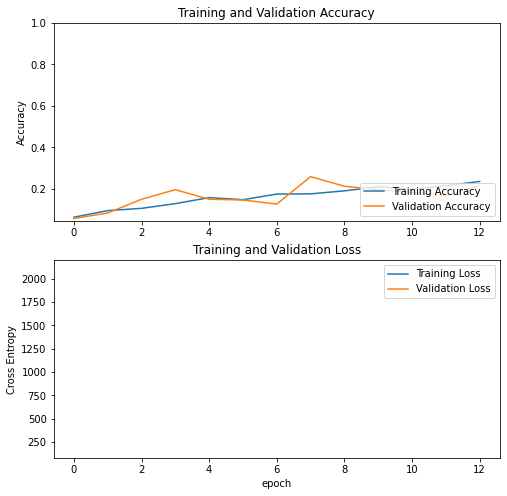

In [ ]:
acc = history_pretrained_ResNet.history['accuracy']
val_acc = history_pretrained_ResNet.history['val_accuracy']

loss = history_pretrained_ResNet.history['loss']
val_loss = history_pretrained_ResNet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([80,2200.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1
import numpy as np
from sklearn.metrics import classification_report

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(pretrain_resnet_model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])


  #print(np.argmax(y.numpy()))

  #print(np.argmax(model.predict(x)))

#print(true_classes)


print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.04      0.40      0.08        10
         2.0       0.04      0.60      0.07        10
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        11
         7.0       0.00      0.00      0.00        10
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00        11
        10.0       0.00      0.00      0.00         7
        11.0       0.00      0.00      0.00         8
        12.0       0.00      0.00      0.00        10
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00         9
        15.0       0.00      0.00      0.00        10
        16.0       0.00      0.00      0.00        12
        17.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Step 8: Pre-Trained Model - InceptionV3**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model_inception = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
print("Number of layers in the InceptionV3 base model: ", len(base_model_inception.layers))

Number of layers in the InceptionV3 base model:  311


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


inceptionv3 = inception_v3.InceptionV3(include_top=False, weights='imagenet',
                                     input_shape=(995,1400,3))

output = inceptionv3.layers[-1].output
output = keras.layers.Flatten()(output)
inceptionv3_model = Model(inceptionv3.input, output)

inceptionv3_model.trainable = False
for layer in inceptionv3_model.layers:
   layer.trainable = False


pretrain_inception_model = Sequential()
pretrain_inception_model.add(Cropping2D(cropping=((1000, 5), (300, 300)), input_shape=(2000,2000,3)))
pretrain_inception_model.add(inceptionv3_model)
pretrain_inception_model.add(Dense(31,kernel_regularizer=regularizers.l2(0.001), activation='softmax'))
pretrain_inception_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

pretrain_inception_model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_6 (Cropping2D)   (None, 995, 1400, 3)      0         
                                                                 
 model_5 (Functional)        (None, 2494464)           21802784  
                                                                 
 dense_6 (Dense)             (None, 31)                77328415  
                                                                 
Total params: 99,131,199
Trainable params: 77,328,415
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
my_callbacks = [

    tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Image_Search/best_model_pretrained_Inception.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

]

history_pretrained_inception=pretrain_inception_model.fit_generator(
        train_generator,
        steps_per_epoch=1102 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=303 // batch_size,callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
551/551 [==============================] - 1316s 2s/step - loss: 374.4047 - accuracy: 0.3258 - val_loss: 343.2061 - val_accuracy: 0.4338

Epoch 00001: val_accuracy improved from -inf to 0.43377, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Inception.hdf5
Epoch 2/50
551/551 [==============================] - 954s 2s/step - loss: 188.8792 - accuracy: 0.6606 - val_loss: 334.1598 - val_accuracy: 0.4901

Epoch 00002: val_accuracy improved from 0.43377 to 0.49007, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Inception.hdf5
Epoch 3/50
551/551 [==============================] - 960s 2s/step - loss: 162.8620 - accuracy: 0.7505 - val_loss: 297.9262 - val_accuracy: 0.6258

Epoch 00003: val_accuracy improved from 0.49007 to 0.62583, saving model to /content/gdrive/My Drive/ISY5002/Project/Image_Search/best_model_pretrained_Inception.hdf5
Epoch 4/50
551/551 [==============================] - 961

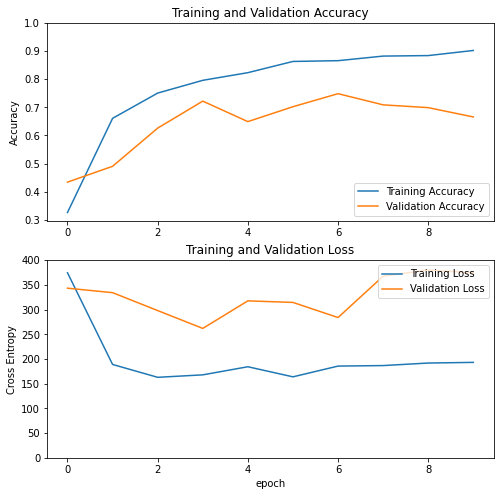

In [ ]:
acc = history_pretrained_inception.history['accuracy']
val_acc = history_pretrained_inception.history['val_accuracy']

loss = history_pretrained_inception.history['loss']
val_loss = history_pretrained_inception.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,400.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pretrain_inception_model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_pretrained_Inception.hdf5")
pretrain_inception_model.summary


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f25e60dda50>>

In [ ]:
#https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac?noredirect=1&lq=1
import numpy as np
from sklearn.metrics import classification_report

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in test_dataset:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(pretrain_inception_model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])


  #print(np.argmax(y.numpy()))

  #print(np.argmax(model.predict(x)))

#print(true_classes)


print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.03      1.00      0.06        10
         2.0       0.00      0.00      0.00        10
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        11
         7.0       0.00      0.00      0.00        10
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00        11
        10.0       0.00      0.00      0.00         7
        11.0       0.00      0.00      0.00         8
        12.0       0.00      0.00      0.00        10
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00         9
        15.0       0.00      0.00      0.00        10
        16.0       0.00      0.00      0.00        12
        17.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Step 9: Ensembling (Baseline + VGG16 + VGG19)**



Ref: https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb

In [ ]:
pretrain_VGG16_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', '/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG.hdf5')
pretrain_ResNet50_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', '/content/gdrive/My Drive/Image_Search/best_model_pretrained_Resnet.hdf5')
pretrain_InceptionV3_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', '/content/gdrive/My Drive/Image_Search/best_model_pretrained_Inception.hdf5')
pretrain_VGG19_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', '/content/gdrive/My Drive/Image_Search/best_model_pretrained_VGG19.hdf5')

#baseline model
model.load_weights("/content/gdrive/My Drive/Image_Search/best_model_baseline.hdf5")

pretrain_vgg_model.load_weights(pretrain_VGG16_WEIGHT_FILE)
pretrain_resnet_model.load_weights(pretrain_ResNet50_WEIGHT_FILE)
pretrain_inception_model.load_weights(pretrain_InceptionV3_WEIGHT_FILE)
pretrain_vgg19_model.load_weights(pretrain_VGG19_WEIGHT_FILE)

ensemble_models = [pretrain_vgg_model,pretrain_vgg19_model]

(-0.5, 833.5, 683.5, -0.5)

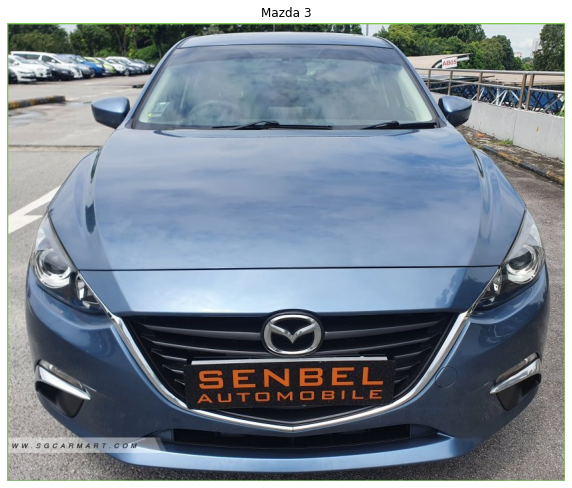

In [ ]:
import cv2
def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return (result, summed)


# example of predicting
img1 = plt.imread('/content/gdrive/My Drive/Image_Search/model_dataset_split/test/Mazda 3/1006563_____15483.jpg')
# Resize it to the net input size:
img = cv2.resize(img1, (2000, 2000))
img = img[np.newaxis, ...]

# Convert the data to float:
img = img.astype(np.float32)

class_index = ensemble_predictions(ensemble_models, img)[0]
# Convert class id to name
labels = ['Audi A3', 'BMW 5', 'Honda Civic', 'Honda Odyssey', 'Honda Stream', 'Hyundai Avante', 'Hyundai Elantra', 'Kia Cerato', 'MINI Cooper', 'Mazda 3', 'Mercedes-Benz A-Class', 'Mercedes-Benz C-Class', 'Mercedes-Benz CLA-Class', 'Mercedes-Benz E-Class', 'Mercedes-Benz GLA-Class', 'Mercedes-Benz S-Class', 'Mitsubishi Lancer', 'Nissan NV200', 'Nissan Qashqai', 'Subaru Forester', 'Suzuki Swift', 'Toyota Camry', 'Toyota Corolla', 'Toyota Estima', 'Toyota Harrier', 'Toyota Hiace', 'Toyota Sienta', 'Toyota Vios', 'Toyota Wish', 'Volkswagen Golf', 'Volkswagen Scirocco']

label = labels[class_index[0]]



plt.figure(figsize=(10, 10))
#plt.imshow(img1.numpy().astype("uint8"))

plt.imshow(img1.astype("uint8"))

plt.title(label)
plt.axis("off")



Found 303 files belonging to 31 classes.


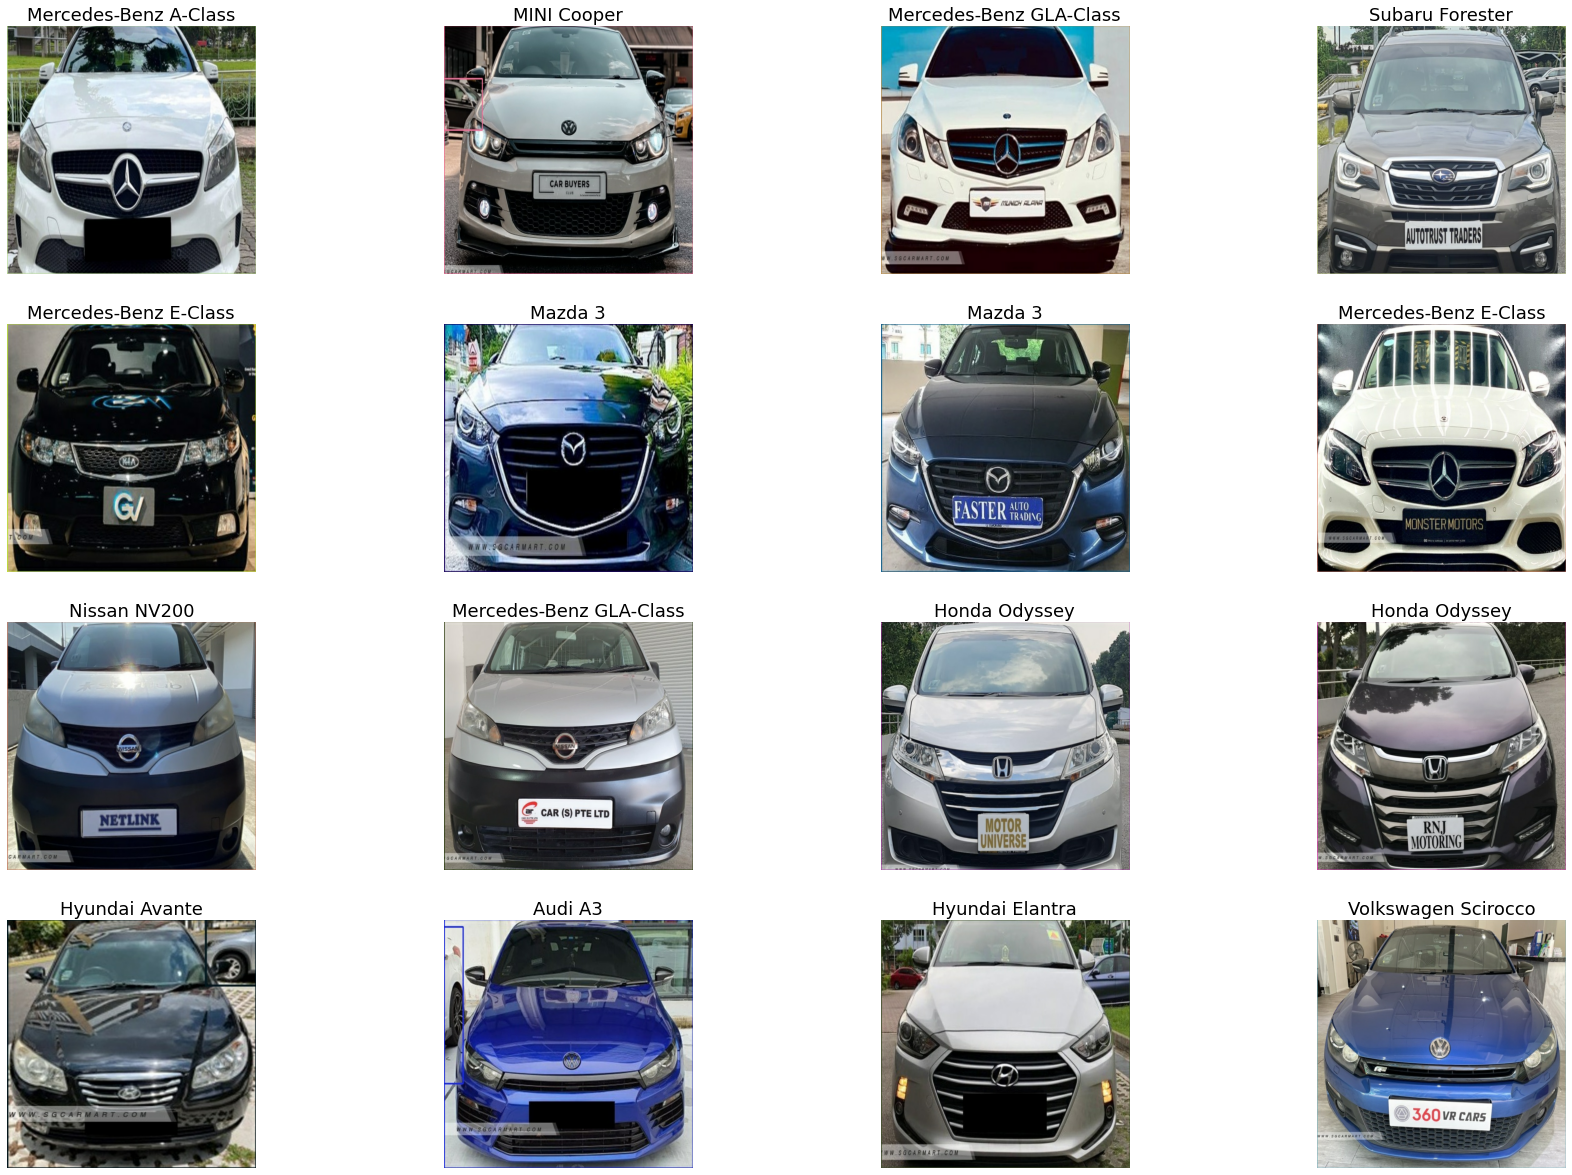

In [ ]:
import cv2
def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.average(yhats, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return (result, summed)


test_dataset_plot = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=1,
                                            image_size=IMG_SIZE,label_mode='categorical')

labels = ['Audi A3', 'BMW 5', 'Honda Civic', 'Honda Odyssey', 'Honda Stream', 'Hyundai Avante', 'Hyundai Elantra', 'Kia Cerato', 'MINI Cooper', 'Mazda 3', 'Mercedes-Benz A-Class', 'Mercedes-Benz C-Class', 'Mercedes-Benz CLA-Class', 'Mercedes-Benz E-Class', 'Mercedes-Benz GLA-Class', 'Mercedes-Benz S-Class', 'Mitsubishi Lancer', 'Nissan NV200', 'Nissan Qashqai', 'Subaru Forester', 'Suzuki Swift', 'Toyota Camry', 'Toyota Corolla', 'Toyota Estima', 'Toyota Harrier', 'Toyota Hiace', 'Toyota Sienta', 'Toyota Vios', 'Toyota Wish', 'Volkswagen Golf', 'Volkswagen Scirocco']

rows = 4
columns = 4
fig = plt.figure(figsize=(30, 21))

i=0
for data, labelz in test_dataset_plot:
# example of predicting
# Resize it to the net input size:


  class_index = ensemble_predictions(models, data)[0]
# Convert class id to name

  label = labels[class_index[0]]

  fig.add_subplot(rows, columns, i+1)

# showing image
  plt.imshow(data[0].numpy().astype("uint8"))
  plt.axis('off')
  plt.title(label, fontsize=18)
  i=i+1
  if i==16:
    break


In [ ]:
prediction_classes = np.array([])
true_classes =  np.array([])

test_dataset_plot = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=1,
                                            image_size=IMG_SIZE,label_mode='categorical')

for data, labelz in test_dataset_plot:

  class_index = ensemble_predictions(ensemble_models, data)[0]

  prediction_classes = np.concatenate([prediction_classes,
                       class_index])
  true_classes = np.concatenate([true_classes, np.argmax(labelz.numpy(), axis=-1)])


print(classification_report(true_classes, prediction_classes))

Found 303 files belonging to 31 classes.
              precision    recall  f1-score   support

         0.0       0.30      1.00      0.47         7
         1.0       0.80      0.80      0.80        10
         2.0       0.86      0.60      0.71        10
         3.0       1.00      0.80      0.89        10
         4.0       1.00      0.42      0.59        12
         5.0       1.00      1.00      1.00         7
         6.0       0.79      1.00      0.88        11
         7.0       0.00      0.00      0.00        10
         8.0       0.50      0.82      0.62        11
         9.0       1.00      0.64      0.78        11
        10.0       0.38      0.71      0.50         7
        11.0       1.00      0.25      0.40         8
        12.0       0.29      0.20      0.24        10
        13.0       0.20      0.90      0.33        10
        14.0       0.27      1.00      0.43         9
        15.0       1.00      0.80      0.89        10
        16.0       1.00      0.25      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
